# Controversy

Hard controversy defined as:
$$H = \frac{1}{c_H} \left[ \sum_{i=0.5}^5 p_i(r_i - \bar{r})^2 \right]^{\frac{1}{2}}$$

Soft controversy defined as:
$$S = 1 - \frac{1}{c_S} \left[ \sum_{i=0.5}^5(p_i - 0.1)^2 \right]^ \frac{1}{2}$$

where $p_i$ is the proportion of ratings for that particular rating (e.g. 3.5) for that movie. $c_H$ and $c_S$ are the respective maximum values for hard and soft controversy, so that they are normalized to between 0 and 1.

In general, as we can see below in the regressions, hard controversy seems to be susceptible to being overfit, and should be the primary metric of choice.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
movies = pd.read_csv('movie_lense/movie_lense/movies.csv')
ratings = pd.read_csv('movie_lense/movie_lense/ratings.csv')
links = pd.read_csv('movie_lense/movie_lense/links.csv')
tags = pd.read_csv('movie_lense/movie_lense/tags.csv')
genome_tags = pd.read_csv('movie_lense/movie_lense/genome-tags.csv')
genome_scores = pd.read_csv('movie_lense/movie_lense/genome-scores.csv')
movie_industry = pd.read_csv('movie_industry.csv', encoding='latin-1')
the_oscar_award = pd.read_csv('the_oscar_award.csv')

In [4]:
movie_ratings_total = movies.merge(ratings, on='movieId', how='left')

In [5]:
movie_ratings = movie_ratings_total[movie_ratings_total.groupby('movieId')['rating'].transform('count') > 30].copy()
movie_ratings['avg_rating'] = movie_ratings.groupby('movieId')['rating'].transform('mean')
movie_ratings['v'] = movie_ratings.groupby(['movieId', 'rating'])['rating'].transform('count')
movie_ratings['N'] = movie_ratings.groupby('movieId')['rating'].transform('count')
movie_ratings['p'] = movie_ratings['v'] / movie_ratings['N']
movie_ratings['hard_controversy'] = (movie_ratings['rating'] - movie_ratings['avg_rating']).pow(2) * movie_ratings['p']
movie_ratings['soft_controversy'] = (movie_ratings['p'] - 0.1).pow(2)
movie_ratings

,movieId,title,genres,userId,rating,timestamp,avg_rating,v,N,p,hard_controversy,soft_controversy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,4.0,1.113766e+09,3.886649,22710,68469,0.331683,0.004262,0.053677
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,5.0,9.488858e+08,3.886649,16497,68469,0.240941,0.298658,0.019864
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.5,1.442169e+09,3.886649,5684,68469,0.083016,0.031230,0.000288
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,4.0,1.370810e+09,3.886649,22710,68469,0.331683,0.004262,0.053677
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,22.0,4.0,1.237623e+09,3.886649,22710,68469,0.331683,0.004262,0.053677
...,...,...,...,...,...,...,...,...,...,...,...,...
27756667,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,270572.0,3.0,1.537208e+09,2.951220,27,82,0.329268,0.000784,0.052564
27756668,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,272459.0,5.0,1.534056e+09,2.951220,7,82,0.085366,0.358323,0.000214
27756669,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,275841.0,1.5,1.533875e+09,2.951220,1,82,0.012195,0.025683,0.007710
27756670,192307,The Meg (2018),Action|Horror|Sci-Fi|Thriller,279522.0,3.0,1.536930e+09,2.951220,27,82,0.329268,0.000784,0.052564


In [6]:
H = movie_ratings.groupby(['movieId', 'rating'])['hard_controversy'].mean().sum(level=0).pow(0.5) / 2

In [7]:
S = 1 - movie_ratings.groupby(['movieId', 'rating'])['soft_controversy'].mean().sum(level=0).pow(0.5) / np.sqrt(0.9)

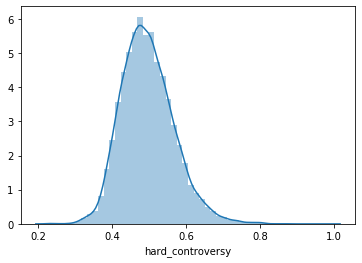

In [8]:
sns.distplot(H)

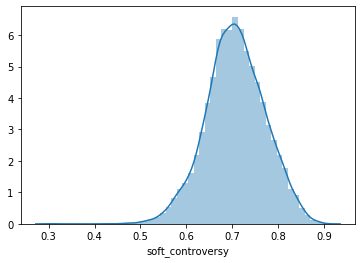

In [9]:
sns.distplot(S)

## Linear Regressions
Input is tag relevancy scores, output is controversy scores

Generate matrix of relevances on tags:

To be used as inputs

In [10]:
relevance_to_rating_df = movies.join(genome_scores.set_index("movieId"), how = "inner", on = "movieId")
relevance_matrix_df = relevance_to_rating_df.set_index(["movieId","tagId"])["relevance"].unstack()
relevance_to_rating_df = relevance_matrix_df.join(H, how="inner", on="movieId").join(S, how="inner", on="movieId")
relevance_to_rating_df

,1,2,3,4,5,6,7,8,9,10,...,1121,1122,1123,1124,1125,1126,1127,1128,hard_controversy,soft_controversy
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,0.464772,0.642883
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,0.479742,0.679760
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,0.507349,0.611081
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500,0.555693,0.624006
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575,0.498123,0.594331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625,0.531250,0.729648
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100,0.499196,0.769825
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925,0.443275,0.697246


### Hard Controversy Regressions

In [11]:
def compute_LR_MSE(X, y, model):
    m, n = X.shape
    y_hat = model.predict(X) 
    MSE = (y_hat - y).dot(y_hat - y)/m
    return MSE

In [12]:
from sklearn.linear_model import LinearRegression
X_relevance_to_rating = relevance_to_rating_df.iloc[:,:-2].to_numpy()
y_relevance_to_rating = relevance_to_rating_df.iloc[:,-2].to_numpy()
model = LinearRegression().fit(X_relevance_to_rating, y_relevance_to_rating)
r_sq = model.score(X_relevance_to_rating, y_relevance_to_rating)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.638715003517261
intercept: 0.545154099424152
coefficients: [ 0.01898011  0.01074455  0.0097394  ... -0.00159773  0.00060735
 -0.00174389]


In [13]:
import statsmodels.api as sm
LR_model = sm.OLS(y_relevance_to_rating, sm.add_constant(X_relevance_to_rating))
LR_results = LR_model.fit()
LR_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     18.88
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:01:42   Log-Likelihood:                 23973.
No. Observations:               13176   AIC:                        -4.569e+04
Df Residuals:                   12047   BIC:                        -3.724e+04
Df Model:                        1128                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5452      0.013     41.059      0.000       0.519       0.571
x1             0.0190      0.013      1.505      0.132      -0.006       0.044
x2             0.0107      0.011      0.990      0.322      -0.011       0.032
x3             0.0097      0.005      1.885      0.059      -0.000       0.020
x4            -0.0077      0.008     -0.949      0.343      -0.024       0.008
x5             0.0042      0.004      1.062      0.288      -0.004       0.012
x6            -0.0075      0.006     -1.195      0.232      -0.020       0.005
x7            -0.0063      0.006     -1.073      0.283      -0.018       0.005
x8            -0.0195      0.005     -4.051      0.000      -0.029      -0.010
x9            -0.0055      0.006     -0.990      0.322      -0.017       0.005
x10           -0.0079      0.007     -1.144      0.252      -0.022       0.006
x11            0.0104      0.007      1.414      0.157      -0.004       0.025
x12           -0.0129      0.005     -2.402      0.016      -0.023      -0.002
x13           -0.0272      0.006     -4.277      0.000      -0.040      -0.015
x14            0.0689      0.014      4.832      0.000       0.041       0.097
x15           -0.0259      0.023     -1.124      0.261      -0.071       0.019
x16            0.0602      0.011      5.376      0.000       0.038       0.082
x17            0.0054      0.011      0.477      0.634      -0.017       0.028
x18           -0.0039      0.006     -0.689      0.491      -0.015       0.007
x19           -0.0070      0.005     -1.358      0.174      -0.017       0.003
x20            0.0106      0.007      1.541      0.123      -0.003       0.024
x21           -0.0034      0.007     -0.474      0.636      -0.017       0.011
x22           -0.0199      0.006     -3.487      0.000      -0.031      -0.009
x23           -0.0151      0.008     -1.885      0.059      -0.031       0.001
x24           -0.0114      0.013     -0.906      0.365      -0.036       0.013
x25           -0.0004      0.007     -0.057      0.954      -0.015       0.014
x26           -0.0132      0.005     -2.424      0.015      -0.024      -0.003
x27            0.0031      0.005      0.617      0.538      -0.007       0.013
x28            0.0069      0.004      1.652      0.099      -0.001       0.015
x29            0.0006      0.005      0.125      0.901      -0.009       0.010
x30           -0.0013      0.005     -0.294      0.769      -0.010       0.008
x31            0.0092      0.010      0.889      0.374      -0.011       0.029
x32            0.0202      0.008      2.442      0.015       0.004       0.036
x33            0.0113      0.009      1.324      0.185      -0.005       0.028
x34           -0.0021      0.005     -0.386      0.699      -0.013       0.008
x35            0.0016      0.006      0.257      0.797      -0.011       0.014
x3

In [14]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating), y_relevance_to_rating, LR_results)

0.0015387387149417581

Check which tags are most associated 

In [15]:
def results_summary_to_dataframe(results):
    """return dataframe from statsmodels summary result"""
    pvals = results.pvalues
    coeff = results.params

    results_df = pd.DataFrame({"pvals":pvals,
                                "coeff":coeff
                                })
    
    return results_df[["coeff","pvals"]]

In [16]:
summary_df = results_summary_to_dataframe(LR_results)

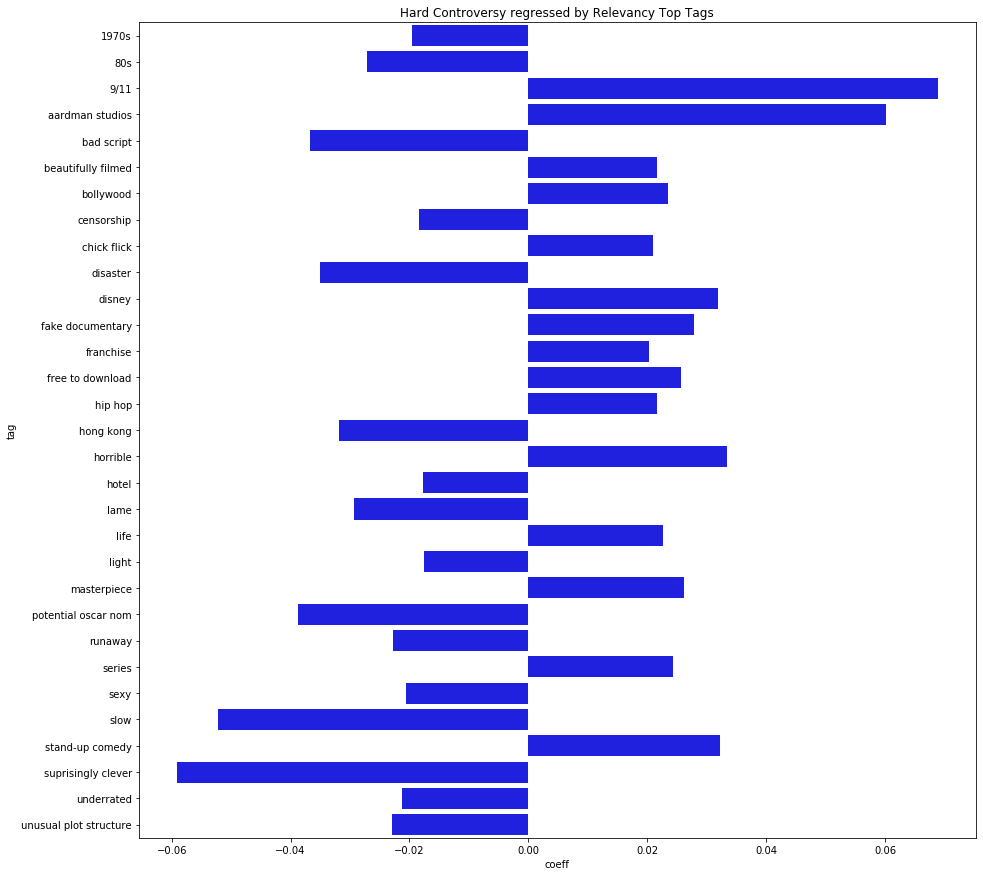

In [17]:
top_tags = genome_tags.join(summary_df[summary_df['pvals'] < 0.0001], how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coeff'], top_tags['tag'],color='blue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags')
plt.show()

### Soft Controversy Regressions

In [18]:
from sklearn.linear_model import LinearRegression
X_relevance_to_rating = relevance_to_rating_df.iloc[:,:-2].to_numpy()
y_relevance_to_rating = relevance_to_rating_df.iloc[:,-1].to_numpy()
model = LinearRegression().fit(X_relevance_to_rating, y_relevance_to_rating)
r_sq = model.score(X_relevance_to_rating, y_relevance_to_rating)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.5862423171354008
intercept: 0.8029717177377136
coefficients: [ 0.00693094 -0.02210131 -0.00258926 ... -0.00062204 -0.00589878
  0.01604236]


In [19]:
import statsmodels.api as sm
LR_model = sm.OLS(y_relevance_to_rating, sm.add_constant(X_relevance_to_rating))
LR_results = LR_model.fit()
LR_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     15.13
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:01:48   Log-Likelihood:                 23371.
No. Observations:               13176   AIC:                        -4.448e+04
Df Residuals:                   12047   BIC:                        -3.603e+04
Df Model:                        1128                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8030      0.014     57.774      0.000       0.776       0.830
x1             0.0069      0.013      0.525      0.600      -0.019       0.033
x2            -0.0221      0.011     -1.946      0.052      -0.044       0.000
x3            -0.0026      0.005     -0.479      0.632      -0.013       0.008
x4            -0.0006      0.008     -0.066      0.948      -0.017       0.016
x5             0.0024      0.004      0.573      0.566      -0.006       0.010
x6            -0.0100      0.007     -1.530      0.126      -0.023       0.003
x7            -0.0019      0.006     -0.311      0.756      -0.014       0.010
x8             0.0061      0.005      1.210      0.226      -0.004       0.016
x9            -0.0052      0.006     -0.884      0.377      -0.017       0.006
x10           -0.0059      0.007     -0.808      0.419      -0.020       0.008
x11            0.0091      0.008      1.182      0.237      -0.006       0.024
x12            0.0100      0.006      1.789      0.074      -0.001       0.021
x13        -6.566e-05      0.007     -0.010      0.992      -0.013       0.013
x14            0.0460      0.015      3.084      0.002       0.017       0.075
x15           -0.0215      0.024     -0.890      0.373      -0.069       0.026
x16            0.0126      0.012      1.072      0.284      -0.010       0.036
x17           -0.0029      0.012     -0.242      0.809      -0.026       0.020
x18            0.0102      0.006      1.741      0.082      -0.001       0.022
x19            0.0067      0.005      1.245      0.213      -0.004       0.017
x20           -0.0307      0.007     -4.271      0.000      -0.045      -0.017
x21           -0.0195      0.007     -2.630      0.009      -0.034      -0.005
x22           -0.0143      0.006     -2.390      0.017      -0.026      -0.003
x23           -0.0206      0.008     -2.453      0.014      -0.037      -0.004
x24            0.0014      0.013      0.108      0.914      -0.024       0.027
x25           -0.0008      0.008     -0.104      0.917      -0.016       0.014
x26           -0.0006      0.006     -0.107      0.915      -0.012       0.011
x27            0.0080      0.005      1.542      0.123      -0.002       0.018
x28            0.0005      0.004      0.110      0.913      -0.008       0.009
x29           -0.0024      0.005     -0.475      0.635      -0.012       0.008
x30            0.0066      0.005      1.376      0.169      -0.003       0.016
x31           -0.0318      0.011     -2.945      0.003      -0.053      -0.011
x32            0.0115      0.009      1.328      0.184      -0.005       0.029
x33            0.0215      0.009      2.403      0.016       0.004       0.039
x34            0.0095      0.006      1.688      0.091      -0.002       0.021
x35           -0.0043      0.007     -0.655      0.512      -0.017       0.009
x3

In [20]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating), y_relevance_to_rating, LR_results)

0.0016860991065813468

In [21]:
summary_df = results_summary_to_dataframe(LR_results)

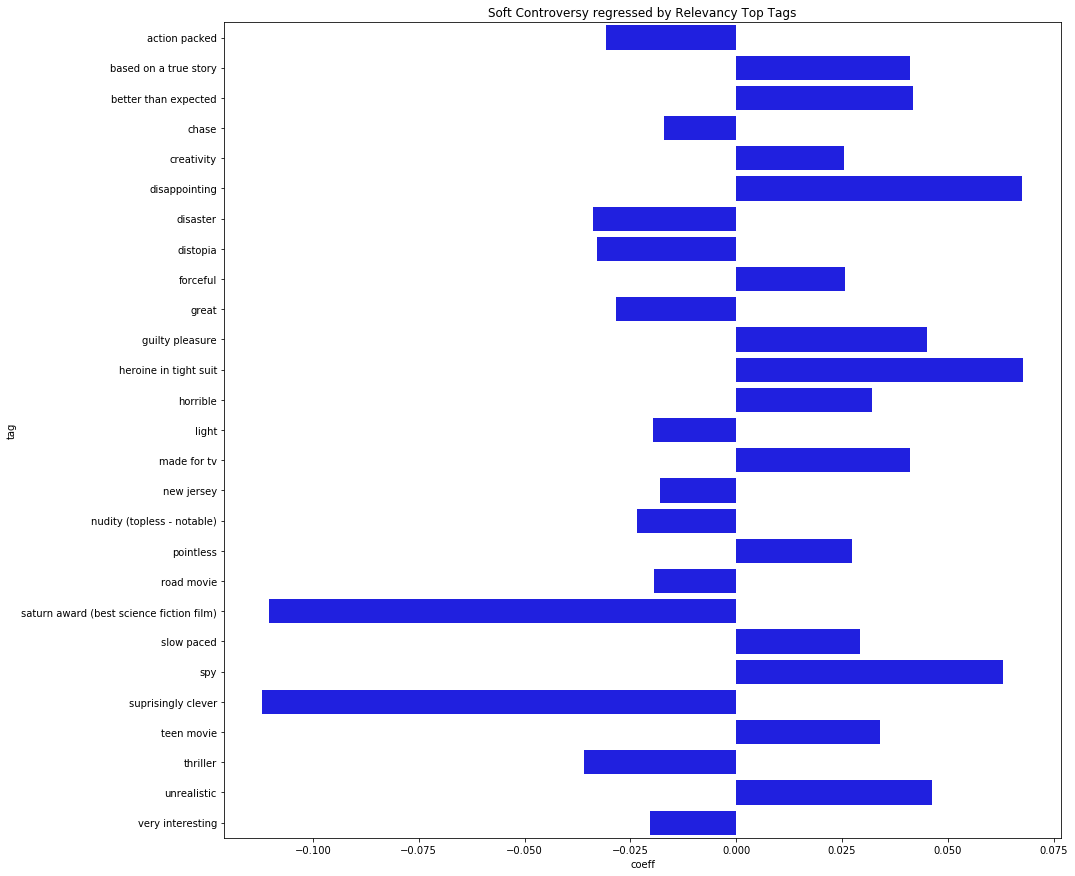

In [22]:
top_tags = genome_tags.join(summary_df[summary_df['pvals'] < 0.0001], how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coeff'], top_tags['tag'],color='blue', orient='h')
plt.title('Soft Controversy regressed by Relevancy Top Tags')
plt.show()

## Train/Test and LASSO - Reducing Overfitting

In [23]:
m,n = relevance_to_rating_df.shape
relevance_to_rating_tr, relevance_to_rating_cv, relevance_to_rating_ts = np.split(relevance_to_rating_df.sample(frac=1).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_tr.shape)
print("cross validation set shape", relevance_to_rating_cv.shape)
print("test set shape", relevance_to_rating_ts.shape)

training set shape (7905, 1130)
cross validation set shape (2635, 1130)
test set shape (2636, 1130)


In [24]:
X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-2]
y_relevance_to_rating_tr = relevance_to_rating_tr[:,-2]

LR_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
LR_results = LR_model.fit()
print("coefficients:", LR_results.params)

coefficients: [ 0.54646252  0.00353945  0.02143847 ... -0.01481534  0.02400257
 -0.02386519]


Compute MSE

In [25]:
X_relevance_to_rating_ts = relevance_to_rating_ts[:,:-2]
y_relevance_to_rating_ts = relevance_to_rating_ts[:,-2]
X_relevance_to_rating_cv = relevance_to_rating_cv[:,:-2]
y_relevance_to_rating_cv = relevance_to_rating_cv[:,-2]
LR_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_results)
LR_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_results)
LR_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_results)
print("Training MSE:", LR_MSE_tr)
print("Testing MSE:", LR_MSE_ts)
print("Cross validation MSE:", LR_MSE_cv)

Training MSE: 0.0014072716405598977
Testing MSE: 0.0020949814875092726
Cross validation MSE: 0.002004701970073575


#### Introducing Regularization

In [26]:
LR_reg_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
alpha = 1
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
print("coefficients:", LR_reg_results.params)

coefficients: [ 5.40125337e-01 -1.41717467e-04 -1.06019895e-04 ... -3.94800037e-04
  4.60112673e-04  1.01560990e-04]


In [27]:
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

Training MSE: 0.002809074730783534
Cross validation MSE: 0.0028751378968018865
Test MSE: 0.003002003586156984


#### Tuning Alpha

In [28]:
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
    LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
    print("When alpha =", alpha)
    print("Training MSE:", LR_reg_MSE_tr)
    print("Cross validation MSE:", LR_reg_MSE_cv)

When alpha = 0
Training MSE: 0.0014072716405598984
Cross validation MSE: 0.002004701970073572
When alpha = 0.0001
Training MSE: 0.0014098494889421727
Cross validation MSE: 0.0019663339730332566
When alpha = 0.0003
Training MSE: 0.0014199167897403408
Cross validation MSE: 0.0019230499052396435
When alpha = 0.001
Training MSE: 0.00145907411423449
Cross validation MSE: 0.0018641485136107684
When alpha = 0.003
Training MSE: 0.001544135155525919
Cross validation MSE: 0.0018402126421480757
When alpha = 0.01
Training MSE: 0.0017024576961290096
Cross validation MSE: 0.0018942268807371908
When alpha = 0.03
Training MSE: 0.0018944860246889244
Cross validation MSE: 0.0020228429099622917
When alpha = 0.1
Training MSE: 0.0021449056162066655
Cross validation MSE: 0.002236668127482473
When alpha = 0.3
Training MSE: 0.002423441576023427
Cross validation MSE: 0.0024999314195044303
When alpha = 1
Training MSE: 0.002809074730783534
Cross validation MSE: 0.0028751378968018865


In [29]:
alpha = 0.0003
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0014199167897403408
Cross validation MSE: 0.0019230499052396435
Test MSE: 0.002024297958559284


In [30]:
reg_summary_df = pd.DataFrame(LR_reg_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


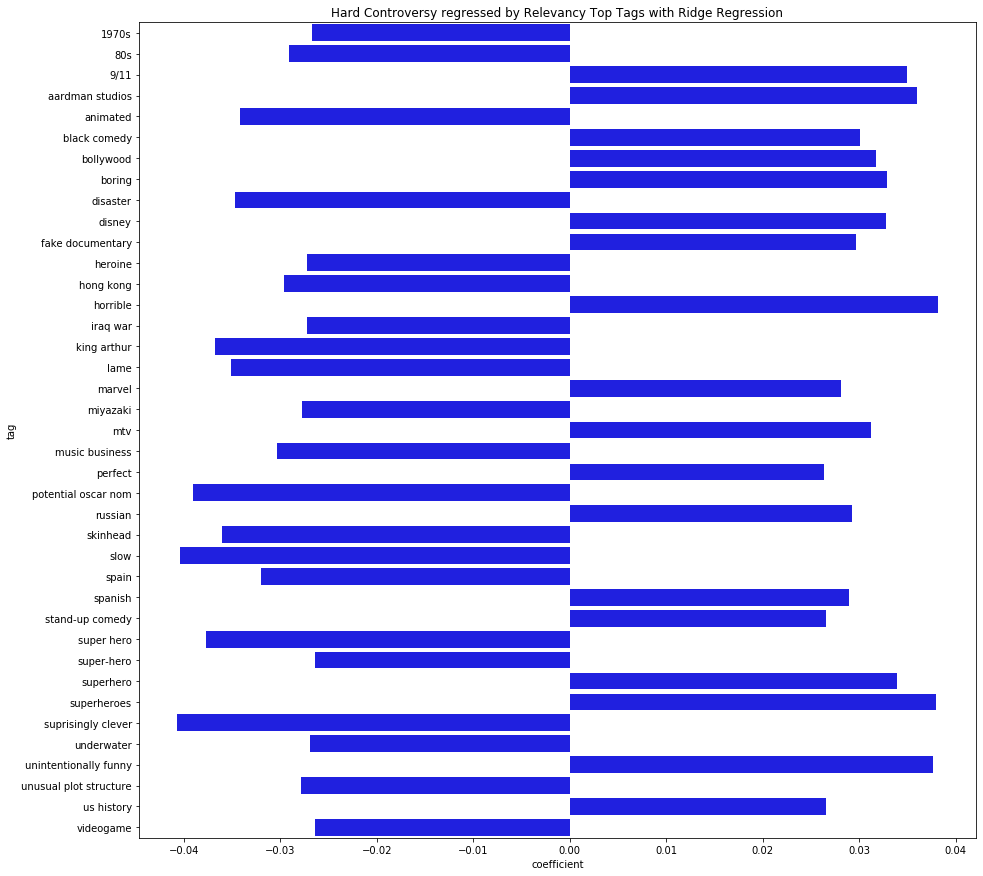

In [31]:
top_tags = genome_tags.join(reg_summary_df.nlargest(40, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='blue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags with Ridge Regression')
plt.show()

## Repeat for Soft Controversy (seems very overfit)

In [32]:
X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-2]
y_relevance_to_rating_tr = relevance_to_rating_tr[:,-1]

LR_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
LR_results = LR_model.fit()
print("coefficients:", LR_results.params)

coefficients: [ 0.81365001 -0.00426025 -0.01319103 ...  0.00579233  0.00100511
  0.01411157]


In [33]:
LR_reg_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
alpha = 1
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
print("coefficients:", LR_reg_results.params)

coefficients: [ 7.31558644e-01 -4.62996456e-05 -1.24369510e-04 ... -2.98030875e-04
  5.21155879e-04  2.40643638e-04]


#### Tuning Alpha

In [34]:
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
    LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
    print("When alpha =", alpha)
    print("Training MSE:", LR_reg_MSE_tr)
    print("Cross validation MSE:", LR_reg_MSE_cv)

When alpha = 0
Training MSE: 0.0015781097775066479
Cross validation MSE: 0.04767133705333651
When alpha = 0.0001
Training MSE: 0.0015811108061658335
Cross validation MSE: 0.04760960195970044
When alpha = 0.0003
Training MSE: 0.0015931595894986992
Cross validation MSE: 0.047524704384373985
When alpha = 0.001
Training MSE: 0.0016389303942351064
Cross validation MSE: 0.04735092574416582
When alpha = 0.003
Training MSE: 0.001738646052599968
Cross validation MSE: 0.047135235292360196
When alpha = 0.01
Training MSE: 0.0019309881362762214
Cross validation MSE: 0.046924265448619176
When alpha = 0.03
Training MSE: 0.00217260017295631
Cross validation MSE: 0.0468333895167558
When alpha = 0.1
Training MSE: 0.0024652178184516285
Cross validation MSE: 0.04686417395395438
When alpha = 0.3
Training MSE: 0.002727810842427051
Cross validation MSE: 0.046980678057749185
When alpha = 1
Training MSE: 0.0030327465188010752
Cross validation MSE: 0.04720427738503518


In [35]:
alpha = 0.0003
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0015931595894986992
Cross validation MSE: 0.047524704384373985
Test MSE: 0.0470755031375062


In [36]:
reg_summary_df = pd.DataFrame(LR_reg_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


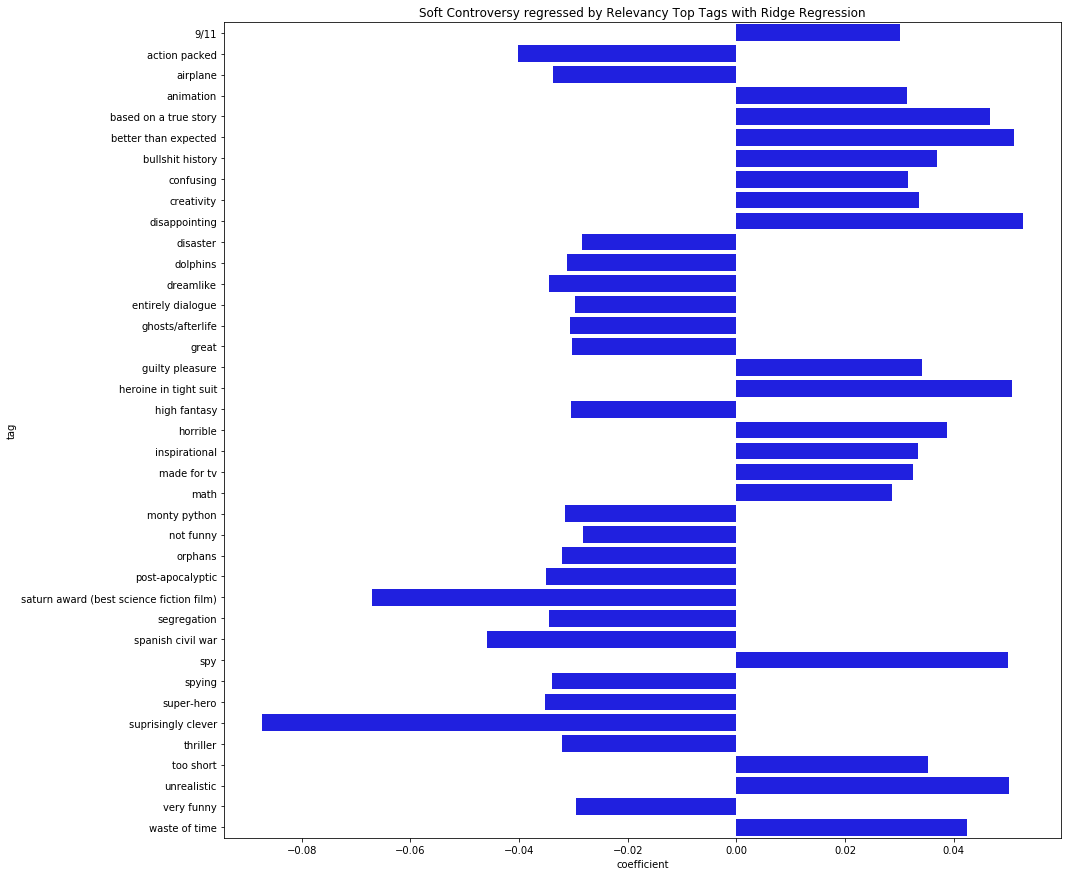

In [37]:
top_tags = genome_tags.join(reg_summary_df.nlargest(40, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='blue', orient='h')
plt.title('Soft Controversy regressed by Relevancy Top Tags with Ridge Regression')
plt.show()

## Finding correlations between tags to reduce feature space

In [38]:
relevance_corr_df = relevance_matrix_df.corr()
relevance_corr_df

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
tagId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.750238,-0.030803,-0.055117,-0.010714,-0.025092,0.169082,-0.002423,0.037608,-0.030121,...,0.044737,0.020648,0.006740,-0.072366,-0.046793,-0.040764,-0.020332,0.011513,-0.026563,-0.029255
2,0.750238,1.000000,-0.019098,-0.038638,0.004226,-0.010537,0.163721,0.002513,0.046954,-0.018468,...,0.033139,0.011203,-0.000700,-0.063766,-0.055521,-0.050397,-0.009879,0.001404,-0.027472,-0.030366
3,-0.030803,-0.019098,1.000000,0.353302,0.256638,0.193530,0.142959,0.097375,-0.004793,0.620194,...,0.067369,0.114708,0.046064,0.094647,-0.042658,0.027473,0.141929,0.046692,-0.081894,-0.015827
4,-0.055117,-0.038638,0.353302,1.000000,0.540420,0.423666,0.243676,0.220936,0.040616,0.394791,...,0.128869,0.186698,0.107791,0.117080,-0.086903,0.020632,0.098091,0.103807,-0.142582,-0.050844
5,-0.010714,0.004226,0.256638,0.540420,1.000000,0.448431,0.251901,0.241134,0.088559,0.304216,...,0.151315,0.250746,0.238796,0.080902,-0.048202,0.043336,0.009830,0.216569,-0.111265,-0.043519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,-0.040764,-0.050397,0.027473,0.020632,0.043336,0.086827,-0.005798,0.101176,0.001051,0.024601,...,0.069868,-0.065284,-0.048983,0.402038,0.643939,1.000000,-0.057903,-0.047726,-0.096522,-0.040045
1125,-0.020332,-0.009879,0.141929,0.098091,0.009830,-0.019271,-0.012248,0.042574,0.004802,0.104903,...,-0.018871,0.003320,-0.014443,0.025242,-0.089879,-0.057903,1.000000,-0.015219,0.007364,0.009714
1126,0.011513,0.001404,0.046692,0.103807,0.216569,0.108880,0.096393,0.101559,0.013886,0.055829,...,0.200383,0.739921,0.950473,-0.002277,-0.117576,-0.047726,-0.015219,1.000000,-0.073597,-0.024862


In [39]:
m,n = relevance_corr_df.shape
for i in range(m):
    for j in range(i+1,m):
        if abs(relevance_corr_df.iat[i,j])> 0.9:
          #print("tagId: "+ str(i+1) +"and tagId: " + str(j+1) + "has correlation " + str(relevance_corr_df.iat[i,j]))
          print("tag <"+ genome_tags.at[i,"tag"] +"> #" +str(i+1)  + " and tag <" + genome_tags.at[j,"tag"] + ">#" + str(j+1) + " has correlation " + str(relevance_corr_df.iat[i,j]))

tag <alien> #43 and tag <aliens>#45 has correlation 0.9480167506065734
tag <animated> #63 and tag <animation>#64 has correlation 0.935088911935152
tag <based on a comic> #108 and tag <based on comic>#114 has correlation 0.9195705740465725
tag <based on a true story> #110 and tag <based on true story>#115 has correlation 0.9134543118654201
tag <based on a true story> #110 and tag <true story>#1047 has correlation 0.9224521267408721
tag <book> #152 and tag <book was better>#153 has correlation 0.9013065033122879
tag <comedy> #230 and tag <funny>#417 has correlation 0.9030930375067381
tag <cute> #278 and tag <cute!>#279 has correlation 0.9089014438452941
tag <dance> #283 and tag <dancing>#284 has correlation 0.900814394204044
tag <feel good movie> #387 and tag <feel-good>#388 has correlation 0.9528472821937137
tag <history> #509 and tag <us history>#1065 has correlation 0.9224942767271389
tag <japan> #575 and tag <japanese>#576 has correlation 0.9086684784196961
tag <kung fu> #592 and tag

#### Reduce the number of features based on correlation

In [40]:
relevance_to_rating_df

,1,2,3,4,5,6,7,8,9,10,...,1121,1122,1123,1124,1125,1126,1127,1128,hard_controversy,soft_controversy
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,0.464772,0.642883
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,0.479742,0.679760
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,0.507349,0.611081
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500,0.555693,0.624006
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575,0.498123,0.594331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625,0.531250,0.729648
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100,0.499196,0.769825
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925,0.443275,0.697246


In [41]:
Cutoff = np.arange(0.3, 0.95, 0.025)
for cutoff in Cutoff:
    upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
    relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)
    relevance_to_rating_red_df

    m,n = relevance_to_rating_red_df.shape
    print(m,n)
    relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
    print("training set shape", relevance_to_rating_red_tr.shape)
    print("cross validation set shape", relevance_to_rating_red_cv.shape)
    print("test set shape", relevance_to_rating_red_ts.shape)
    X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-2]
    y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-2]
    X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-2]
    y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-2]
    X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-2]
    y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-2]
    LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))

    for alpha in [0, 0.0001, 0.0003, 0.001]:
        Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
        Alpha[0] = 0 # do not penalize the constant coefficient
        LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
        LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
        LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
        print("When cutoff, alpha =", cutoff, alpha,)
        print("Training MSE:", LR_rel_red_reg_MSE_tr)
        print("Cross validation MSE:", LR_rel_red_reg_MSE_cv)

13176 105
training set shape (7905, 105)
cross validation set shape (2635, 105)
test set shape (2636, 105)
When cutoff, alpha = 0.3 0
Training MSE: 0.002729081479144566
Cross validation MSE: 0.0027264005613221814
When cutoff, alpha = 0.3 0.0001
Training MSE: 0.0027296444868764543
Cross validation MSE: 0.002726121974531781
When cutoff, alpha = 0.3 0.0003
Training MSE: 0.0027327450056563456
Cross validation MSE: 0.0027283698576008515
When cutoff, alpha = 0.3 0.001
Training MSE: 0.002750113354412666
Cross validation MSE: 0.0027440474742476983
13176 127
training set shape (7905, 127)
cross validation set shape (2635, 127)
test set shape (2636, 127)
When cutoff, alpha = 0.325 0
Training MSE: 0.0024831524471456124
Cross validation MSE: 0.0024768734563232623
When cutoff, alpha = 0.325 0.0001
Training MSE: 0.002483817518803585
Cross validation MSE: 0.002475671789611079
When cutoff, alpha = 0.325 0.0003
Training MSE: 0.002487087331298471
Cross validation MSE: 0.002477220783124648
When cutoff, a

When cutoff, alpha = 0.6250000000000002 0.001
Training MSE: 0.0017347894176435422
Cross validation MSE: 0.0018753046003999645
13176 683
training set shape (7905, 683)
cross validation set shape (2635, 683)
test set shape (2636, 683)
When cutoff, alpha = 0.6500000000000004 0
Training MSE: 0.0016789093603603717
Cross validation MSE: 0.0019238517046621716
When cutoff, alpha = 0.6500000000000004 0.0001
Training MSE: 0.0016800185849326049
Cross validation MSE: 0.0019074436794377385
When cutoff, alpha = 0.6500000000000004 0.0003
Training MSE: 0.001685235704221466
Cross validation MSE: 0.0018880776030567115
When cutoff, alpha = 0.6500000000000004 0.001
Training MSE: 0.0017084131547845567
Cross validation MSE: 0.0018622522254824962
13176 735
training set shape (7905, 735)
cross validation set shape (2635, 735)
test set shape (2636, 735)
When cutoff, alpha = 0.6750000000000003 0
Training MSE: 0.0016318554542786715
Cross validation MSE: 0.0019015813273837883
When cutoff, alpha = 0.67500000000000

#### Selecting Best Model based on CV: 0.85 cutoff, 0.001 regularization alpha

In [42]:
upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if (any(upper[column] > 0.85) or any(upper[column] < -0.85))]
relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)

m,n = relevance_to_rating_red_df.shape
print(m,n)
relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_red_tr.shape)
print("cross validation set shape", relevance_to_rating_red_cv.shape)
print("test set shape", relevance_to_rating_red_ts.shape)
X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-2]
y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-2]
X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-2]
y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-2]
X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-2]
y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-2]
LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))


Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * 0.001
Alpha[0] = 0 # do not penalize the constant coefficient
LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
print("When cutoff, alpha =", 0.85, 0.001,)
print("Training MSE:", LR_rel_red_reg_MSE_tr)
print("Cross validation MSE:", LR_rel_red_reg_MSE_cv)

13176 1060
training set shape (7905, 1060)
cross validation set shape (2635, 1060)
test set shape (2636, 1060)
When cutoff, alpha = 0.85 0.001
Training MSE: 0.0015024162057793492
Cross validation MSE: 0.0017689304739196422


In [43]:
X_relevance_to_rating_red = relevance_to_rating_red_df.values[:,:-2]
y_relevance_to_rating_red = relevance_to_rating_red_df.values[:,-2]
LR_model = sm.OLS(y_relevance_to_rating_red, sm.add_constant(X_relevance_to_rating_red))
LR_red_results = LR_model.fit()
LR_red_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     19.82
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:06:19   Log-Likelihood:                 23883.
No. Observations:               13176   AIC:                        -4.565e+04
Df Residuals:                   12117   BIC:                        -3.772e+04
Df Model:                        1058                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5480      0.013     42.318      0.000       0.523       0.573
x1             0.0196      0.011      1.864      0.062      -0.001       0.040
x2             0.0062      0.011      0.577      0.564      -0.015       0.027
x3             0.0098      0.005      1.893      0.058      -0.000       0.020
x4            -0.0089      0.008     -1.108      0.268      -0.025       0.007
x5             0.0028      0.004      0.711      0.477      -0.005       0.011
x6            -0.0090      0.006     -1.447      0.148      -0.021       0.003
x7            -0.0046      0.006     -0.779      0.436      -0.016       0.007
x8            -0.0192      0.005     -3.996      0.000      -0.029      -0.010
x9            -0.0062      0.006     -1.103      0.270      -0.017       0.005
x10           -0.0089      0.007     -1.282      0.200      -0.022       0.005
x11            0.0135      0.007      1.855      0.064      -0.001       0.028
x12           -0.0132      0.005     -2.461      0.014      -0.024      -0.003
x13           -0.0274      0.006     -4.325      0.000      -0.040      -0.015
x14            0.0674      0.014      4.731      0.000       0.039       0.095
x15           -0.0301      0.023     -1.313      0.189      -0.075       0.015
x16            0.0598      0.011      5.342      0.000       0.038       0.082
x17            0.0051      0.011      0.453      0.651      -0.017       0.027
x18           -0.0006      0.006     -0.103      0.918      -0.011       0.010
x19           -0.0036      0.005     -0.723      0.470      -0.013       0.006
x20            0.0007      0.007      0.103      0.918      -0.013       0.015
x21           -0.0183      0.006     -3.255      0.001      -0.029      -0.007
x22           -0.0123      0.008     -1.591      0.112      -0.027       0.003
x23           -0.0094      0.013     -0.746      0.456      -0.034       0.015
x24           -0.0006      0.007     -0.076      0.940      -0.015       0.014
x25           -0.0135      0.005     -2.526      0.012      -0.024      -0.003
x26            0.0027      0.005      0.537      0.591      -0.007       0.012
x27            0.0070      0.004      1.674      0.094      -0.001       0.015
x28            0.0005      0.005      0.095      0.925      -0.009       0.010
x29           -0.0004      0.005     -0.091      0.927      -0.009       0.009
x30            0.0101      0.010      0.975      0.330      -0.010       0.030
x31            0.0215      0.008      2.606      0.009       0.005       0.038
x32            0.0108      0.009      1.262      0.207      -0.006       0.028
x33           -0.0025      0.005     -0.472      0.637      -0.013       0.008
x34            0.0014      0.006      0.219      0.827      -0.011       0.014
x35           -0.0043      0.006     -0.753      0.452      -0.016       0.007
x3

### Simple Model with fewer features
For visual and explanation purposes

In [44]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red), y_relevance_to_rating_red, LR_red_results)

0.0015599017214259542

In [45]:
reg_summary_df = pd.DataFrame(LR_red_results.params, columns=['coefficient'])
reg_summary_df['magnitude'] = reg_summary_df['coefficient'].abs()


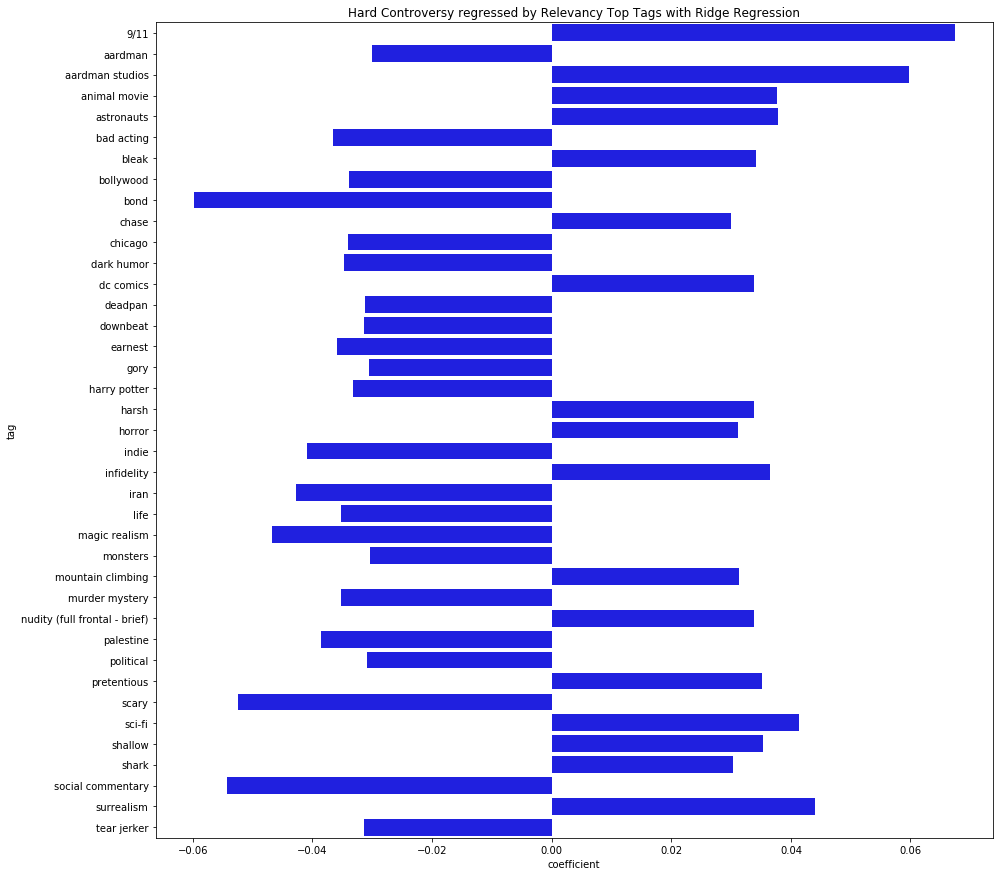

In [46]:
top_tags = genome_tags.join(reg_summary_df.nlargest(40, 'magnitude'), how='inner', on='tagId')
plt.figure(figsize=(15, 15))
sns.barplot(top_tags['coefficient'], top_tags['tag'],color='blue', orient='h')
plt.title('Hard Controversy regressed by Relevancy Top Tags with Ridge Regression')
plt.show()

#### Hypothesis Testing

Controversy vs. Rating. Seems to be significantly negatively correlated.

In [47]:
H

movieId
1         0.464772
2         0.479742
3         0.507349
4         0.555693
5         0.498123
            ...   
191997    0.349676
191999    0.344223
192081    0.462692
192283    0.482016
192307    0.527606
Name: hard_controversy, Length: 15751, dtype: float64

In [58]:
avg_ratings = movie_ratings.groupby('movieId')['rating'].mean()

In [60]:
LR_model = sm.OLS(avg_ratings, sm.add_constant(H))
controversy_ratings_results = LR_model.fit()
controversy_ratings_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     3182.
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:46:55   Log-Likelihood:                -9409.2
No. Observations:               15751   AIC:                         1.882e+04
Df Residuals:                   15749   BIC:                         1.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.6322      0.025    188.438      0.000       4.584       4.680
hard_controversy    -2.7657      0.049    -56.408      0.000      -2.862      -2.670
==============================================================================
Omnibus:                     1049.288   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1360.149
Skew:                          -0.615   Prob(JB):                    4.44e-296
Kurtosis:                       3.748   Cond. No.                         17.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
LR_model = sm.OLS(avg_ratings, sm.add_constant(S))
controversy_ratings_results = LR_model.fit()
controversy_ratings_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     2370.
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:42:11   Log-Likelihood:                -9754.6
No. Observations:               15751   AIC:                         1.951e+04
Df Residuals:                   15749   BIC:                         1.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.1741      0.039    131.020      0.000       5.097       5.252
soft_controversy    -2.7082      0.056    -48.678      0.000      -2.817      -2.599
==============================================================================
Omnibus:                     3142.001   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7186.783
Skew:                          -1.136   Prob(JB):                         0.00
Kurtosis:                       5.406   Cond. No.                         23.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Controversy vs. Awards

In [84]:
movie_H['title'] = movie_H['title'].astype('string')
movie_H

,movieId,title,genres,hard_controversy
11702,51372,"""Great Performances"" Cats (1998)",Musical,0.763468
16930,85177,$ (Dollars) (1971),Comedy|Crime|Drama,0.530100
15912,80361,$5 a Day (2008),Comedy|Drama,0.525310
14938,74486,$9.99 (2008),Animation,0.588847
25816,117867,'71 (2014),Action|Drama|Thriller|War,0.406406
...,...,...,...,...
46424,167738,xXx: Return of Xander Cage (2017),Action|Adventure|Crime|Thriller,0.603993
10074,33158,xXx: State of the Union (2005),Action|Crime|Thriller,0.571580
2394,2478,¡Three Amigos! (1986),Comedy|Western,0.516997
12448,57706,À nos amours (1983),Drama|Romance,0.528079


In [78]:
awards = the_oscar_award[['film', 'winner']].dropna().sort_values('film')
awards['film'] = awards['film'].astype('string')

In [85]:
awards

,film,winner
404,"$1,000 a Minute",False
6528,'38',False
6569,'Crocodile' Dundee,False
6469,'Round Midnight,False
6535,'Round Midnight,True
...,...,...
7522,the end,False
3459,tom thumb,True
165,À Nous la Liberté,False
4723,Ådalen '31,False


In [83]:
movie_H = movies.join(H, on='movieId', how='inner').sort_values('title')
pd.merge_asof(movie_H, 
              awards, 
              left_on='title', 
              right_on='film', 
              direction='nearest')

MergeError: incompatible merge keys [0] dtype('O') and StringDtype, must be the same type

In [63]:
the_oscar_award

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10390,2019,2020,92,WRITING (Original Screenplay),"Screenplay by Bong Joon Ho, Han Jin Won; Story...",Parasite,True
10391,2019,2020,92,JEAN HERSHOLT HUMANITARIAN AWARD,Geena Davis,NaN,True
10392,2019,2020,92,HONORARY AWARD,David Lynch,NaN,True
10393,2019,2020,92,HONORARY AWARD,Wes Studi,NaN,True


In [7]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [7]:
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [4]:
movie_industry

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0.0,Fox Searchlight Pictures,UK,Mandie Fletcher,Comedy,4750497.0,Absolutely Fabulous: The Movie,R,2016-07-22,91,5.4,Jennifer Saunders,9161,Jennifer Saunders,2016
6816,0.0,Siempre Viva Productions,USA,Paul Duddridge,Drama,28368.0,Mothers and Daughters,PG-13,2016-05-06,90,4.9,Selma Blair,1959,Paige Cameron,2016
6817,3500000.0,Warner Bros. Animation,USA,Sam Liu,Animation,3775000.0,Batman: The Killing Joke,R,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016
6818,0.0,Borderline Presents,USA,Nicolas Pesce,Drama,25981.0,The Eyes of My Mother,R,2016-12-02,76,6.2,Kika Magalhães,6947,Nicolas Pesce,2016
